In [1]:
import numpy as np 
import pandas as pd
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import time
import datetime
from datetime import datetime
import calendar

from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
import graphviz
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix


sns.set_style('white')

pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# reduces the memory of a dataframe
def reduce_mem_usage(df, verbose = True):
    
    '''
    Reduces the space that a DataFrame occupies in memory.

    This function iterates over all columns in a df and downcasts them to lower type to save memory.
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'\
              .format(end_mem, 100 * (start_mem - end_mem) / start_mem))

In [26]:
df_sorted = pd.read_pickle('../../Datos/EasyMoney_base.pkl',compression='zip')

In [27]:
df_sorted.isnull().sum().sum()

0

In [28]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962924 entries, 0 to 5962923
Data columns (total 59 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   pk_cid                  int32         
 1   pk_partition            datetime64[ns]
 2   short_term_deposit      int8          
 3   loans                   int8          
 4   mortgage                int8          
 5   funds                   int8          
 6   securities              int8          
 7   long_term_deposit       int8          
 8   em_account_pp           int8          
 9   credit_card             int8          
 10  payroll                 float16       
 11  pension_plan            float16       
 12  payroll_account         int8          
 13  emc_account             int8          
 14  debit_card              int8          
 15  em_account_p            int8          
 16  em_acount               int8          
 17  entry_date              datetime64[ns]
 18  en

# Vamos a hacer el producto cartesiano para predecir
Solo clientes activos(Con producto)

In [29]:
lista_fechas=['2018-01-28',
'2018-02-28',
'2018-03-28',
'2018-04-28',
'2018-05-28',
'2018-06-28',
'2018-07-28',
'2018-08-28',
'2018-09-28',
'2018-10-28',
'2018-11-28',
'2018-12-28',
'2019-01-28',
'2019-02-28',
'2019-03-28',
'2019-04-28',
'2019-05-28',             
'2019-06-28']

In [30]:
lista_clientes=df_sorted[(df_sorted['isActive']==1) & 
                        (df_sorted['pk_partition']=='2019-05-28')]["pk_cid"].unique().tolist()

In [31]:
lista_clientes=df_sorted[(df_sorted['pk_partition']=='2019-05-28')]["pk_cid"].unique().tolist()

In [32]:
len(lista_clientes)

442995

In [33]:
cartesian_product = pd.MultiIndex.from_product([lista_fechas, lista_clientes ], names = ["pk_partition", "pk_cid"])
len(cartesian_product)

7973910

In [34]:
cartesian_product

MultiIndex([('2018-01-28',   16063),
            ('2018-01-28',   16203),
            ('2018-01-28',   16502),
            ('2018-01-28',   17457),
            ('2018-01-28',   17590),
            ('2018-01-28',   17799),
            ('2018-01-28',   17970),
            ('2018-01-28',   17980),
            ('2018-01-28',   18146),
            ('2018-01-28',   18704),
            ...
            ('2019-06-28', 1553679),
            ('2019-06-28', 1553680),
            ('2019-06-28', 1553681),
            ('2019-06-28', 1553683),
            ('2019-06-28', 1553684),
            ('2019-06-28', 1553685),
            ('2019-06-28', 1553686),
            ('2019-06-28', 1553687),
            ('2019-06-28', 1553688),
            ('2019-06-28', 1553689)],
           names=['pk_partition', 'pk_cid'], length=7973910)

In [35]:
full_df = pd.DataFrame(index = cartesian_product).reset_index()
full_df.tail()

,pk_partition,pk_cid
7973905,2019-06-28,1553685
7973906,2019-06-28,1553686
7973907,2019-06-28,1553687
7973908,2019-06-28,1553688
7973909,2019-06-28,1553689


In [36]:
full_df['pk_partition']=pd.to_datetime(full_df['pk_partition'], format='%Y-%m-%d')

In [37]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    442995
2018-02-28    442995
2018-03-28    442995
2018-04-28    442995
2018-05-28    442995
2018-06-28    442995
2018-07-28    442995
2018-08-28    442995
2018-09-28    442995
2018-10-28    442995
2018-11-28    442995
2018-12-28    442995
2019-01-28    442995
2019-02-28    442995
2019-03-28    442995
2019-04-28    442995
2019-05-28    442995
2019-06-28    442995
Name: pk_cid, dtype: int64

In [38]:
full_df = pd.merge(full_df,df_sorted , on = ["pk_partition", "pk_cid"], how = 'left')

In [39]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    442995
2018-02-28    442995
2018-03-28    442995
2018-04-28    442995
2018-05-28    442995
2018-06-28    442995
2018-07-28    442995
2018-08-28    442995
2018-09-28    442995
2018-10-28    442995
2018-11-28    442995
2018-12-28    442995
2019-01-28    442995
2019-02-28    442995
2019-03-28    442995
2019-04-28    442995
2019-05-28    442995
2019-06-28    442995
Name: pk_cid, dtype: int64

In [40]:
del df_sorted

In [41]:
gc.collect()

60

In [42]:
#full_df.to_pickle('fulldf_base.pkl',compression='zip')

In [43]:
# Nulos debidos al producto cartesiano
full_df[full_df['entry_date'].isnull()].groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    206825
2018-02-28    203940
2018-03-28    201278
2018-04-28    199132
2018-05-28    196740
2018-06-28    194630
2018-07-28    109709
2018-08-28     96053
2018-09-28     73906
2018-10-28     47121
2018-11-28     32470
2018-12-28     25695
2019-01-28     19481
2019-02-28     13916
2019-03-28      8804
2019-04-28      4588
2019-06-28    442995
Name: pk_cid, dtype: int64

In [44]:
full_df

,pk_partition,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,totalAhorro,totalFinanciacion,totalIngresos,totalBeneficio,hayAlta,diasDesdeUltimaAlta,diasDesdeUltimaAltaInt,hayBaja,diasDesdeUltimaBaja,diasDesdeUltimaBajaInt
0,2018-01-28,16063,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,nan
1,2018-01-28,16203,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,nan
2,2018-01-28,16502,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,nan
3,2018-01-28,17457,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,1.00,0.00,0.00,90.00,0.00,1 days 00:00:00,1.00,0.00,1 days 00:00:00,1.00
4,2018-01-28,17590,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7973905,2019-06-28,1553685,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,nan
7973906,2019-06-28,1553686,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,nan
7973907,2019-06-28,1553687,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,nan
7973908,2019-06-28,1553688,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,NaN,nan,nan,NaN,nan


In [45]:
# Borramos todos los nulos que se generan por el producto cartesiano:
full_df.drop (full_df[ (full_df['pk_partition']!='2019-06-28') &
                       (full_df['entry_date'].isnull()) ].index, axis=0, inplace=True)

In [46]:
full_df[full_df['entry_date'].isnull()].groupby('pk_partition')['pk_cid'].size()

pk_partition
2019-06-28    442995
Name: pk_cid, dtype: int64

In [47]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    236170
2018-02-28    239055
2018-03-28    241717
2018-04-28    243863
2018-05-28    246255
2018-06-28    248365
2018-07-28    333286
2018-08-28    346942
2018-09-28    369089
2018-10-28    395874
2018-11-28    410525
2018-12-28    417300
2019-01-28    423514
2019-02-28    429079
2019-03-28    434191
2019-04-28    438407
2019-05-28    442995
2019-06-28    442995
Name: pk_cid, dtype: int64

In [48]:
# Actualizamos el mes a predecir:2019-06-28 con los valores de los clientes 
lista_actualizar=['entry_date',
 #'entry_channel',
 'active_customer',
 #'segment',
 #'country_id',
 'region_code',
 #'gender',
 'age',
 #'deceased', 
 #'mesesAlta',
'salary']

In [49]:
# Rellenamos entry_date para el ultimo mes:
for x in lista_actualizar:
    print(x)
    full_df.loc[(full_df['pk_partition']=='2019-06-28'),
            x]=full_df[full_df['pk_partition']=='2019-06-28']['pk_cid'].map(full_df[['pk_cid',x]].groupby('pk_cid')[x].max())

entry_date
active_customer
region_code
age
salary


In [50]:
# Solo tenemos nulos en el mes a predecir
full_df.isnull().sum()

pk_partition                   0
pk_cid                         0
short_term_deposit        442995
loans                     442995
mortgage                  442995
funds                     442995
securities                442995
long_term_deposit         442995
em_account_pp             442995
credit_card               442995
payroll                   442995
pension_plan              442995
payroll_account           442995
emc_account               442995
debit_card                442995
em_account_p              442995
em_acount                 442995
entry_date                     0
entry_channel             442995
active_customer                0
segment                   442995
country_id                442995
region_code                    0
gender                    442995
age                            0
deceased                  442995
salary                         0
dif_debit_card            442995
dif_em_account_p          442995
dif_em_account_pp         442995
dif_em_aco

In [51]:
full_df[(full_df['isNewClient']==0) &
                     (full_df['isActive']==0)].T

,10,35,43,50,72,107,121,145,177,186,...,7530905,7530906,7530907,7530908,7530909,7530910,7530911,7530912,7530913,7530914
pk_partition,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,2018-01-28 00:00:00,...,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00,2019-05-28 00:00:00
pk_cid,18956,25612,29896,31512,35849,44949,46823,53836,63478,65506,...,1553679,1553680,1553681,1553683,1553684,1553685,1553686,1553687,1553688,1553689
short_term_deposit,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
loans,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
mortgage,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
funds,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
securities,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
long_term_deposit,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
em_account_pp,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
credit_card,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [52]:
# Borramos los meses que no pasa nada para que el modelo aprenda a coger emjor los cambios.
#El rendimiento del modelo mejora con esto:
full_df.drop(full_df[(full_df['isNewClient']==0) &
                     (full_df['isActive']==0)].index ,axis=0, inplace=True)

In [53]:
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    232033
2018-02-28    234815
2018-03-28    237501
2018-04-28    239649
2018-05-28    242132
2018-06-28    244123
2018-07-28    257780
2018-08-28    271829
2018-09-28    290119
2018-10-28    312974
2018-11-28    318715
2018-12-28    319997
2019-01-28    323405
2019-02-28    326834
2019-03-28    329686
2019-04-28    332144
2019-05-28    334193
2019-06-28    442995
Name: pk_cid, dtype: int64

In [58]:
full_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290924 entries, 3 to 7973909
Data columns (total 59 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   pk_partition            datetime64[ns]
 1   pk_cid                  int32         
 2   short_term_deposit      float16       
 3   loans                   float16       
 4   mortgage                float16       
 5   funds                   float16       
 6   securities              float16       
 7   long_term_deposit       float16       
 8   em_account_pp           float16       
 9   credit_card             float16       
 10  payroll                 float16       
 11  pension_plan            float16       
 12  payroll_account         float16       
 13  emc_account             float16       
 14  debit_card              float16       
 15  em_account_p            float16       
 16  em_acount               float16       
 17  entry_date              datetime64[ns]
 18  en

In [55]:
reduce_mem_usage(full_df, verbose = True)

Mem. usage decreased to 988.98 Mb (42.0% reduction)


In [56]:
#full_df.to_pickle('fulldf_base_nandropped.pkl',compression='zip')

In [59]:
delta_productos_easymoney=['dif_loans',
 'dif_mortgage',
 'dif_funds',
 'dif_securities',
 'dif_long_term_deposit',
 'dif_short_term_deposit',                          
 'dif_em_account_pp',
 'dif_credit_card',
 'dif_payroll',
 'dif_pension_plan',
 'dif_payroll_account',
 'dif_emc_account',
 'dif_debit_card',
 'dif_em_acount',
 'dif_em_account_p']

In [60]:
productos_easymoney=['loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'short_term_deposit',                    
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_acount',
 'em_account_p']

Ponemos a 0 las bajas para solo predecir altas:

In [61]:
for x in delta_productos_easymoney:
      full_df.loc[full_df[x]==-1, x ]=0  

In [64]:
full_df['dif_em_acount'].value_counts()

0.00    4721831
1.00     126098
Name: dif_em_acount, dtype: int64

In [65]:
full_df['dif_credit_card'].value_counts()

0.00    4836944
1.00      10985
Name: dif_credit_card, dtype: int64

In [66]:
full_df.to_pickle('./fulldf_base_V1.pkl',compression='zip')

In [119]:
full_df=pd.read_pickle('./fulldf_base_V1.pkl',compression='zip')

In [67]:
for x in [1,2,3,4,5,6]:
    print(x)
    full_df['em_acount_shift_'+str(x)]=full_df.groupby(['pk_cid'])['em_acount'].shift(x)

1
2
3
4
5
6


In [69]:
ver=['pk_cid','pk_partition','em_acount','em_acount_shift_1','em_acount_shift_2',
     'em_acount_shift_3','em_acount_shift_4','em_acount_shift_5','em_acount_shift_6']

In [70]:
full_df[full_df['pk_cid']==1035440  ][ver].head(10).T

,29295,472290,915285,1358280,1801275,2244270,2687265,3130260,3573255,4016250
pk_cid,1035440,1035440,1035440,1035440,1035440,1035440,1035440,1035440,1035440,1035440
pk_partition,2018-01-28 00:00:00,2018-02-28 00:00:00,2018-03-28 00:00:00,2018-04-28 00:00:00,2018-05-28 00:00:00,2018-06-28 00:00:00,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-09-28 00:00:00,2018-10-28 00:00:00
em_acount,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
em_acount_shift_1,NaN,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
em_acount_shift_2,NaN,NaN,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00
em_acount_shift_3,NaN,NaN,NaN,1.00,0.00,0.00,1.00,1.00,1.00,1.00
em_acount_shift_4,NaN,NaN,NaN,NaN,1.00,0.00,0.00,1.00,1.00,1.00
em_acount_shift_5,NaN,NaN,NaN,NaN,NaN,1.00,0.00,0.00,1.00,1.00
em_acount_shift_6,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.00,0.00,1.00


In [71]:
for x in [1,2,3,4,5,6]:
    print(x)
    full_df['totalAssets_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalAssets'].shift(x)

1
2
3
4
5
6


In [72]:
ver=['pk_cid','pk_partition','totalAssets','totalAssets_shift_1','totalAssets_shift_2',
     'totalAssets_shift_3','totalAssets_shift_4','totalAssets_shift_5','totalAssets_shift_6']

In [73]:
full_df[full_df['pk_cid']==1035440  ][ver].head(10).T

,29295,472290,915285,1358280,1801275,2244270,2687265,3130260,3573255,4016250
pk_cid,1035440,1035440,1035440,1035440,1035440,1035440,1035440,1035440,1035440,1035440
pk_partition,2018-01-28 00:00:00,2018-02-28 00:00:00,2018-03-28 00:00:00,2018-04-28 00:00:00,2018-05-28 00:00:00,2018-06-28 00:00:00,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-09-28 00:00:00,2018-10-28 00:00:00
totalAssets,2.00,1.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00
totalAssets_shift_1,NaN,2.00,1.00,1.00,2.00,1.00,2.00,2.00,2.00,2.00
totalAssets_shift_2,NaN,NaN,2.00,1.00,1.00,2.00,1.00,2.00,2.00,2.00
totalAssets_shift_3,NaN,NaN,NaN,2.00,1.00,1.00,2.00,1.00,2.00,2.00
totalAssets_shift_4,NaN,NaN,NaN,NaN,2.00,1.00,1.00,2.00,1.00,2.00
totalAssets_shift_5,NaN,NaN,NaN,NaN,NaN,2.00,1.00,1.00,2.00,1.00
totalAssets_shift_6,NaN,NaN,NaN,NaN,NaN,NaN,2.00,1.00,1.00,2.00


# Feature engeniering

In [120]:
for y in delta_productos_easymoney:
    print(y)
    for x in [1,2,3,4,5,6]:
        print(x)
        full_df[y+'_shift_'+str(x)]=full_df.groupby(['pk_cid'])[y].shift(x)

dif_loans
1
2
3
4
5
6
dif_mortgage
1
2
3
4
5
6
dif_funds
1
2
3
4
5
6
dif_securities
1
2
3
4
5
6
dif_long_term_deposit
1
2
3
4
5
6
dif_short_term_deposit
1
2
3
4
5
6
dif_em_account_pp
1
2
3
4
5
6
dif_credit_card
1
2
3
4
5
6
dif_payroll
1
2
3
4
5
6
dif_pension_plan
1
2
3
4
5
6
dif_payroll_account
1
2
3
4
5
6
dif_emc_account
1
2
3
4
5
6
dif_debit_card
1
2
3
4
5
6
dif_em_acount
1
2
3
4
5
6
dif_em_account_p
1
2
3
4
5
6


In [121]:
for y in productos_easymoney:
    print(y)
    for x in [1,2,3,4,5,6]:
        print(x)
        full_df[y+'_shift_'+str(x)]=full_df.groupby(['pk_cid'])[y].shift(x)

loans
1
2
3
4
5
6
mortgage
1
2
3
4
5
6
funds
1
2
3
4
5
6
securities
1
2
3
4
5
6
long_term_deposit
1
2
3
4
5
6
short_term_deposit
1
2
3
4
5
6
em_account_pp
1
2
3
4
5
6
credit_card
1
2
3
4
5
6
payroll
1
2
3
4
5
6
pension_plan
1
2
3
4
5
6
payroll_account
1
2
3
4
5
6
emc_account
1
2
3
4
5
6
debit_card
1
2
3
4
5
6
em_acount
1
2
3
4
5
6
em_account_p
1
2
3
4
5
6


In [122]:
for x in [1,2,3,4,5,6]:
    print(x)
    full_df['isActive_shift_'+str(x)]=full_df.groupby(['pk_cid'])['isActive'].shift(x)
    full_df['isNewClient_shift_'+str(x)]=full_df.groupby(['pk_cid'])['isNewClient'].shift(x)
    full_df['active_customer_shift_'+str(x)]=full_df.groupby(['pk_cid'])['active_customer'].shift(x)
    full_df['totalAssets_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalAssets'].shift(x)
    full_df['totalCuentas_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalCuentas'].shift(x)
    full_df['totalAhorro_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalAhorro'].shift(x)
    full_df['totalFinanciacion_shift_'+str(x)]=full_df.groupby(['pk_cid'])['totalFinanciacion'].shift(x)
    full_df['totalIngresos_'+str(x)]=full_df.groupby(['pk_cid'])['totalIngresos'].shift(x)
    full_df['totalBeneficio_'+str(x)]=full_df.groupby(['pk_cid'])['totalBeneficio'].shift(x)
    full_df['diasDesdeUltimaAltaInt_'+str(x)]=full_df.groupby(['pk_cid'])['diasDesdeUltimaAltaInt'].shift(x)
    full_df['hayAlta_'+str(x)]=full_df.groupby(['pk_cid'])['hayAlta'].shift(x)
    full_df['diasDesdeUltimaBajaInt_'+str(x)]=full_df.groupby(['pk_cid'])['diasDesdeUltimaAltaInt'].shift(x)
    full_df['hayBaja_'+str(x)]=full_df.groupby(['pk_cid'])['hayAlta'].shift(x)

1
2
3
4
5
6


In [128]:
# Rellenamos los nulos producidos en las shift
full_df.fillna(-999,inplace=True)

In [3]:
full_df.to_pickle('./fulldf_base_V2.pkl',compression='zip')

NameError: name 'full_df' is not defined

In [3]:
full_df=pd.read_pickle('./fulldf_base_V2.pkl',compression='zip')

In [37]:
full_df["day"] = full_df["pk_partition"].dt.day
full_df["year"] = full_df["pk_partition"].dt.year
full_df["month"] = full_df["pk_partition"].dt.month

In [38]:
full_df["entry_date_day"] = full_df["entry_date"].dt.day
full_df["entry_date_year"] = full_df["entry_date"].dt.year
full_df["entry_date_month"] = full_df["entry_date"].dt.month

In [42]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5063970 entries, 2 to 5968583
Columns: 323 entries, pk_partition to entry_date_month
dtypes: datetime64[ns](2), float16(149), float32(1), float64(155), int64(7), object(9)
memory usage: 8.0+ GB


In [43]:
# Solo hay nulos en el mes a predecir:
full_df[full_df['pk_partition']<
        '2019-06-28'].isnull().sum().sum()

0

In [40]:
reduce_mem_usage(full_df, verbose = True)

Mem. usage decreased to 3632.99 Mb (5.3% reduction)


In [41]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290924 entries, 3 to 7973909
Columns: 323 entries, pk_partition to entry_date_month
dtypes: datetime64[ns](2), float16(304), float32(1), int16(2), int32(1), int8(4), object(9)
memory usage: 3.5+ GB


In [46]:
gc.collect()

29089

In [42]:
full_df['entry_channel'].value_counts(dropna=False).head(10)

KHE     2682591
KFC      642547
KHQ      443661
-999     442995
KAT      336817
KHK      165437
KHM      127410
XXX      114477
KHN       85196
KHD       63473
Name: entry_channel, dtype: int64

In [43]:
full_df.loc[full_df['entry_channel']==-999,'entry_channel']='XXX'

In [44]:
full_df['entry_channel']=pd.Categorical(full_df['entry_channel'], categories=full_df['entry_channel'].value_counts(dropna=False).head(10).index.to_list())

In [45]:
full_df['entry_channel'].value_counts(dropna=False)

KHE    2682591
KFC     642547
XXX     557472
KHQ     443661
KAT     336817
KHK     165437
KHM     127410
NaN     125365
KHN      85196
KHD      63473
KFA      60955
Name: entry_channel, dtype: int64

In [46]:
dummy_dataset = pd.get_dummies(full_df['entry_channel'],prefix='channel')

In [47]:
dummy_dataset

,channel_KHE,channel_KFC,channel_XXX,channel_KHQ,channel_KAT,channel_KHK,channel_KHM,channel_KHN,channel_KHD,channel_KFA
3,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0
11,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7973905,0,0,1,0,0,0,0,0,0,0
7973906,0,0,1,0,0,0,0,0,0,0
7973907,0,0,1,0,0,0,0,0,0,0
7973908,0,0,1,0,0,0,0,0,0,0


In [48]:
full_df = pd.concat([full_df,dummy_dataset],axis=1)

In [6]:
full_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290924 entries, 3 to 7973909
Data columns (total 317 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   pk_partition                    datetime64[ns]
 1   pk_cid                          int32         
 2   short_term_deposit              float16       
 3   loans                           float16       
 4   mortgage                        float16       
 5   funds                           float16       
 6   securities                      float16       
 7   long_term_deposit               float16       
 8   em_account_pp                   float16       
 9   credit_card                     float16       
 10  payroll                         float16       
 11  pension_plan                    float16       
 12  payroll_account                 float16       
 13  emc_account                     float16       
 14  debit_card                      float16       
 1

In [49]:
full_df['country_id'].value_counts(dropna=False)

ES       4846124
-999      442995
Other        696
GB           374
FR           202
DE           188
CH           156
US            86
BR            66
BE            37
Name: country_id, dtype: int64

In [50]:
full_df.loc[full_df['country_id']==-999,'country_id']='Other'

In [51]:
full_df['country_id'].value_counts(dropna=False)

ES       4846124
Other     443691
GB           374
FR           202
DE           188
CH           156
US            86
BR            66
BE            37
Name: country_id, dtype: int64

In [52]:
dummy_dataset = pd.get_dummies(full_df['country_id'],prefix='country')

In [53]:
full_df = pd.concat([full_df,dummy_dataset],axis=1)

In [54]:
full_df

,pk_partition,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,...,channel_KFA,country_BE,country_BR,country_CH,country_DE,country_ES,country_FR,country_GB,country_Other,country_US
3,2018-01-28,17457,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
5,2018-01-28,17799,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
6,2018-01-28,17970,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
9,2018-01-28,18704,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0,0,0,0,0,1,0,0,0,0
11,2018-01-28,19021,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7973905,2019-06-28,1553685,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,0,0,0,0,0,0,0,0,1,0
7973906,2019-06-28,1553686,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,0,0,0,0,0,0,0,0,1,0
7973907,2019-06-28,1553687,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,0,0,0,0,0,0,0,0,1,0
7973908,2019-06-28,1553688,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,0,0,0,0,0,0,0,0,1,0


In [55]:
reduce_mem_usage(full_df, verbose = True)

Mem. usage decreased to 3693.54 Mb (0.0% reduction)


In [62]:
full_df.to_pickle('./fulldf_base_nandropped_FEOk.pkl',compression='zip')

In [182]:
#del full_df

In [56]:
gc.collect()

40

In [3]:
full_df=pd.read_pickle('./fulldf_base_nandropped_FEOk.pkl',compression='zip')

# medias moviles

In [131]:
full_df["em_acount_MA2M"]=full_df["em_acount"].rolling(window = 2).sum().shift()

In [132]:
variable_ver=['pk_cid','isNewClient','isActive','em_acount','em_acount_MA2M','dif_em_acount','dif_em_acount_MA2M']

In [133]:
full_df[full_df['pk_cid']==81958  ][variable_ver].head().T

pk_partition,2018-07-28,2018-08-28,2018-09-28,2018-10-28,2018-11-28
pk_cid,"81,958.00","81,958.00","81,958.00","81,958.00","81,958.00"
isNewClient,1.00,0.00,0.00,0.00,0.00
isActive,1.00,1.00,1.00,1.00,1.00
em_acount,1.00,1.00,1.00,1.00,1.00
em_acount_MA2M,2.00,2.00,2.00,2.00,2.00
dif_em_acount,1.00,0.00,0.00,0.00,0.00
dif_em_acount_MA2M,0.00,0.00,0.00,0.00,0.00


In [4]:
full_df["em_acount"].rolling(window = 4).sum().shift()

2               nan
3               nan
4               nan
7               nan
8              3.00
             ...   
5968579   -3,996.00
5968580   -3,996.00
5968581   -3,996.00
5968582   -3,996.00
5968583   -3,996.00
Name: em_acount, Length: 5063970, dtype: float64

In [5]:
for y in productos_easymoney:
    print(y)
    for x in [2,4,6]:
        print(x)
        full_df[y+'_MA'+str(x)+'M']=full_df[y].rolling(window = x).sum().shift()

NameError: name 'productos_easymoney' is not defined

In [137]:
variable_ver=['pk_cid','isNewClient','isActive','em_acount',
              'em_acount_MA2M','em_acount_MA4M','em_acount_MA6M']

In [140]:
full_df[full_df['pk_cid']==1035440  ][variable_ver].head(10).T

pk_partition,2018-01-28,2018-02-28,2018-03-28,2018-04-28,2018-05-28,2018-06-28,2018-07-28,2018-08-28,2018-09-28,2018-10-28
pk_cid,"1,035,440.00","1,035,440.00","1,035,440.00","1,035,440.00","1,035,440.00","1,035,440.00","1,035,440.00","1,035,440.00","1,035,440.00","1,035,440.00"
isNewClient,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
isActive,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
em_acount,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
em_acount_MA2M,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00
em_acount_MA4M,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00
em_acount_MA6M,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00,6.00


# Cambiamos -1 por 0

In [8]:
delta_productos_easymoney

['dif_loans',
 'dif_mortgage',
 'dif_funds',
 'dif_securities',
 'dif_long_term_deposit',
 'dif_short_term_deposit',
 'dif_em_account_pp',
 'dif_credit_card',
 'dif_payroll',
 'dif_pension_plan',
 'dif_payroll_account',
 'dif_emc_account',
 'dif_debit_card',
 'dif_em_acount',
 'dif_em_account_p']

In [65]:
full_df.loc[full_df['dif_em_acount']==-1, 'dif_em_acount' ]=0

In [9]:
for x in delta_productos_easymoney:
      full_df.loc[full_df[x]==-1, x ]=0  

In [10]:
full_df['dif_em_acount'].value_counts()

0.00       4613569
-999.00     331588
1.00        118813
Name: dif_em_acount, dtype: int64

In [3]:
full_df['dif_debit_card'].value_counts()

0.00       4661398
-999.00     331588
1.00         70984
Name: dif_debit_card, dtype: int64

In [4]:
full_df[full_df['pk_partition']=='2019-05-28']['dif_em_acount'].value_counts()

0.00    327603
1.00      3985
Name: dif_em_acount, dtype: int64

In [104]:
#full_df=full_df[full_df['dif_em_acount']==0]

# Entrenar modelo

In [4]:
# split the data into train, validation and test dataset
train_index = sorted(list(full_df["pk_partition"].unique()))[5:-3]

valida_index = [sorted(list(full_df["pk_partition"].unique()))[-3]]

test_index = [sorted(list(full_df["pk_partition"].unique()))[-2]]

In [68]:
len(lista_fechas)

18

In [63]:
gc.collect()

20

In [58]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5290924 entries, 3 to 7973909
Columns: 342 entries, pk_partition to country_US
dtypes: category(1), datetime64[ns](2), float16(304), float32(1), int16(2), int32(1), int8(4), object(8), uint8(19)
memory usage: 3.6+ GB


In [250]:
#full_df=full_df[full_df['isNewClient']==0]

In [5]:
lista_borrar=['totalBeneficio','totalBeneficio_1','totalBeneficio_2','totalBeneficio_3',
              'totalBeneficio_4','totalBeneficio_5','totalBeneficio_6']

In [6]:
full_df.drop(lista_borrar,axis=1, inplace=True)

In [37]:
lista_borrar=['totalCuentas','totalCuentas_shift_1','totalCuentas_shift_2','totalCuentas_shift_3',
              'totalCuentas_shift_4','totalCuentas_shift_5','totalCuentas_shift_6']

In [38]:
full_df.drop(lista_borrar,axis=1, inplace=True)

In [131]:
variables_borrar=['pk_cid', 
"pk_partition",
'segment',
'gender', 
'deceased',
'entry_date',
'mesesAlta',
'entry_channel',
'isNewClient',
'isActive',
'active_customer',
'totalAssets',
'Provincia',
'SalaryQtil',
'totalCuentas',
'totalAhorro',
'totalFinanciacion',  
'totalIngresos',
'totalBeneficio',
'diasDesdeUltimaAltaInt',
'diasDesdeUltimaAlta',
'hayAlta', 
'diasDesdeUltimaBajaInt',
'diasDesdeUltimaBaja',
'hayBaja',           
'country_id',                 
 'dif_loans',
 'dif_mortgage',
 'dif_funds',
 'dif_securities',
 'dif_long_term_deposit',
 'dif_short_term_deposit',
 'dif_em_account_pp',
 'dif_credit_card',
 'dif_payroll',
 'dif_pension_plan',
 'dif_payroll_account',
 'dif_emc_account',
 'dif_debit_card',
 'dif_em_acount',
 'dif_em_account_p',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'short_term_deposit',
 'em_account_pp',
 'credit_card',
 'payroll',
 'pension_plan',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_acount',
 'em_account_p']

In [39]:
variables_borrar=['pk_cid',
'pk_partition',
'short_term_deposit',
'loans',
'mortgage',
'funds',
'securities',
'long_term_deposit',
'em_account_pp',
'credit_card',
'payroll',
'pension_plan',
'payroll_account',
'emc_account',
'debit_card',
'em_account_p',
'em_acount',
'entry_date',
'entry_channel',
'active_customer',
'segment',
'country_id',
'region_code',
'gender',
'age',
'deceased',
'salary',
'dif_debit_card',
'dif_em_account_p',
'dif_em_account_pp',
'dif_em_acount',
'dif_emc_account',
'dif_payroll',
'dif_payroll_account',
'dif_funds',
'dif_long_term_deposit',
'dif_mortgage',
'dif_pension_plan',
'dif_securities',
'dif_short_term_deposit',
'dif_loans',
'dif_credit_card',
'mesesAlta',
'isNewClient',
'isActive',
'Provincia',
'SalaryQtil',
'totalAssets',
#'totalCuentas',
'totalAhorro',
'totalFinanciacion',
'totalIngresos',
#'totalBeneficio',
'hayAlta',
'diasDesdeUltimaAlta',
'diasDesdeUltimaAltaInt',
'hayBaja',
'diasDesdeUltimaBaja',
'diasDesdeUltimaBajaInt']


In [107]:
del X_train,Y_train, X_valida, Y_valida,X_test,Y_test

In [108]:
gc.collect()

52476

In [40]:
X_train = full_df[full_df["pk_partition"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = full_df[full_df["pk_partition"].isin(train_index)]['dif_em_acount']

X_valida = full_df[full_df["pk_partition"].isin(valida_index)].drop(variables_borrar, axis=1)
Y_valida = full_df[full_df["pk_partition"].isin(valida_index)]['dif_em_acount']

X_test = full_df[full_df["pk_partition"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = full_df[full_df["pk_partition"].isin(test_index)]['dif_em_acount']




In [244]:
X_train = full_df[full_df["pk_partition"].isin(train_index)].drop(variables_borrar, axis=1)
Y_train = full_df[full_df["pk_partition"].isin(train_index)]['dif_debit_card']

X_valida = full_df[full_df["pk_partition"].isin(valida_index)].drop(variables_borrar, axis=1)
Y_valida = full_df[full_df["pk_partition"].isin(valida_index)]['dif_debit_card']

X_test = full_df[full_df["pk_partition"].isin(test_index)].drop(variables_borrar, axis = 1)
Y_test = full_df[full_df["pk_partition"].isin(test_index)]['dif_debit_card']

In [11]:
#del full_df

In [64]:
gc.collect()

108

In [9]:
dt = DecisionTreeClassifier(max_depth=6,random_state=42)
    

In [41]:
dt.fit(X_train,Y_train)
    

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [42]:
score_train=dt.score(X_train, Y_train)
score_test=dt.score(X_valida, Y_valida)
print('Resultados para: Train: {} - Test: {}'.format(score_train,score_test))


Resultados para: Train: 0.9812493031125082 - Test: 0.98862842622477


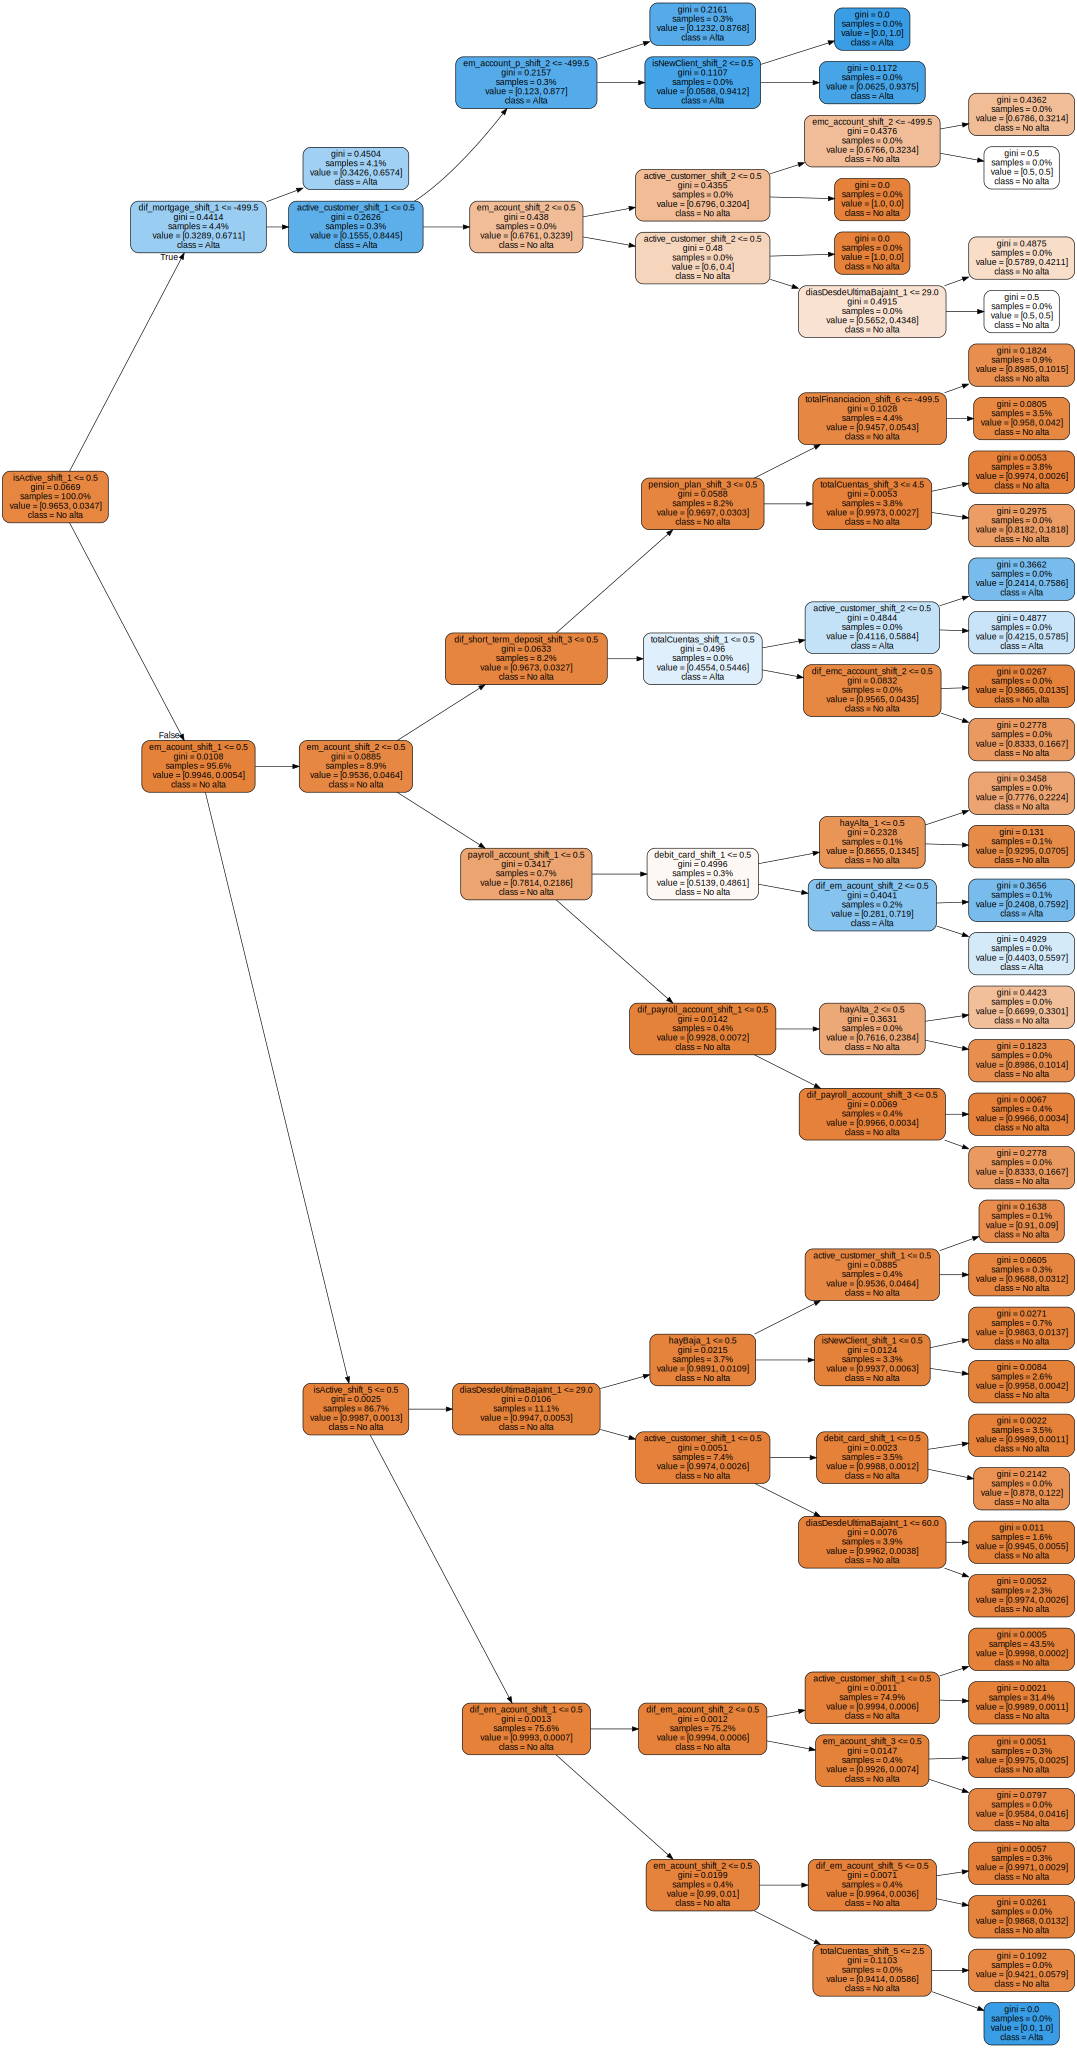

In [12]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        # out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        class_names=['No alta', 'Alta'],
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

graph = graphviz.Source(dot_data)
graph

In [14]:
type(graph)

graphviz.files.Source

In [16]:
graph.render(filename='arbol_EasyMoney')

'arbol_EasyMoney.pdf'

In [16]:
RANDOM_STATE=42

In [19]:
lista_x=[]
lista_strain=[]
lista_svalida=[]
for x in range(10,500,50):
    dt = DecisionTreeClassifier(max_depth=6,random_state=RANDOM_STATE,min_samples_split=x)
    dt.fit(X_train,Y_train)
    score_train=dt.score(X_train, Y_train)
    score_valida=dt.score(X_valida, Y_valida)
    print('Resultados para min_samples_split: {} Train: {} - Valida: {}'.format(x,score_train,score_valida))
    lista_x.append(x)
    lista_strain.append(score_train)
    lista_svalida.append(score_valida)
score_df=pd.DataFrame(index=lista_x, data={'Score_train':lista_strain, 'Score_valida':lista_svalida})

Resultados para min_samples_split: 10 Train: 0.9916418446472851 - Valida: 0.9947191565260268
Resultados para min_samples_split: 60 Train: 0.9916373897059327 - Valida: 0.994737418808934
Resultados para min_samples_split: 110 Train: 0.9916373897059327 - Valida: 0.994737418808934
Resultados para min_samples_split: 160 Train: 0.9916373897059327 - Valida: 0.994737418808934


KeyboardInterrupt: 

In [20]:
lista_x=[]
lista_strain=[]
lista_svalida=[]
for x in range(2,20):
    dt = DecisionTreeClassifier(max_depth=6,random_state=RANDOM_STATE,min_samples_split=100,  min_samples_leaf=x)
    dt.fit(X_train,Y_train)
    score_train=dt.score(X_train, Y_train)
    score_valida=dt.score(X_valida, Y_valida)
    print('Resultados para min_samples_split: {} Train: {} - Valida: {}'.format(x,score_train,score_valida))
    lista_x.append(x)
    lista_strain.append(score_train)
    lista_svalida.append(score_valida)
score_df=pd.DataFrame(index=lista_x, data={'Score_train':lista_strain, 'Score_valida':lista_svalida})

Resultados para min_samples_split: 2 Train: 0.9916373897059327 - Valida: 0.994737418808934
Resultados para min_samples_split: 3 Train: 0.9916367043303401 - Valida: 0.994737418808934


KeyboardInterrupt: 

# Vemos con Test

In [43]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=Y_test.index, columns=['altaPrediction'])

In [44]:
len(y_test_pred)

334193

In [45]:
score_test=dt.score(X_test, Y_test)

In [46]:
score_test

0.9883121429832462

In [47]:
results_df = Y_test.to_frame().join(y_test_pred)

In [48]:
results_df['Success']=(results_df['dif_em_acount']==results_df['altaPrediction']).astype(int)

In [49]:
results_df[results_df['dif_em_acount']!=0].sample(20)

,dif_em_acount,altaPrediction,Success
7526579,1.00,1.00,1
7528468,1.00,1.00,1
7398936,1.00,0.00,0
7388879,1.00,0.00,0
7501522,1.00,0.00,0
7117674,1.00,1.00,1
7525097,1.00,1.00,1
7512093,1.00,1.00,1
7527298,1.00,1.00,1
7526354,1.00,1.00,1


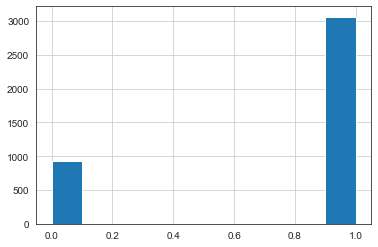

In [50]:
results_df[results_df['dif_em_acount']==1]['Success'].hist()

In [51]:
results_df[results_df['dif_em_acount']==1]['Success'].value_counts()

1    3062
0     923
Name: Success, dtype: int64

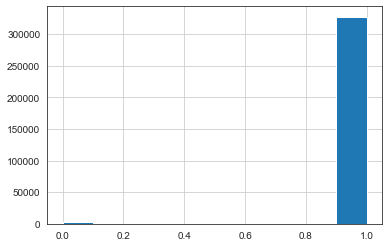

In [52]:
results_df[results_df['dif_em_acount']==0]['Success'].hist()

In [53]:
results_df[results_df['dif_em_acount']==0]['Success'].value_counts()

1    327225
0      2983
Name: Success, dtype: int64

In [54]:
top_features = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(30)

In [55]:
top_features

isActive_shift_1                 0.93
payroll_account_shift_1          0.02
debit_card_shift_1               0.01
em_acount_shift_2                0.01
em_acount_shift_1                0.01
hayBaja_1                        0.01
dif_short_term_deposit_shift_3   0.01
active_customer_shift_1          0.00
pension_plan_shift_3             0.00
dif_em_account_p_shift_6         0.00
dif_em_acount_shift_2            0.00
diasDesdeUltimaAltaInt_1         0.00
totalAssets_shift_1              0.00
totalIngresos_1                  0.00
payroll_account_shift_2          0.00
totalAssets_shift_5              0.00
hayAlta_2                        0.00
em_acount_shift_3                0.00
active_customer_shift_3          0.00
isNewClient_shift_1              0.00
dif_em_acount_shift_1            0.00
active_customer_shift_2          0.00
dif_em_acount_shift_3            0.00
diasDesdeUltimaBajaInt_1         0.00
payroll_shift_2                  0.00
dif_payroll_account_shift_3      0.00
isActive_shi

# Matriz de confusion:

In [30]:
# La podemos calcular directamente con la funcion confusion_matrix de skitlearn
conf_matrix=confusion_matrix(Y_test, dt.predict(X_test))

In [31]:
conf_matrix

array([[327225,   2983],
       [   923,   3062]], dtype=int64)

In [32]:
# Tambien la podemos definir asi:
conf_matrix = pd.crosstab(results_df['dif_em_acount'], results_df['altaPrediction'])

In [33]:
conf_matrix

altaPrediction,0.00,1.00
dif_em_acount,,
0.00,327225,2983
1.00,923,3062


In [34]:
TP = conf_matrix.iloc[1,1]
TN = conf_matrix.iloc[0,0]
FP = conf_matrix.iloc[0,1]
FN = conf_matrix.iloc[1,0]

In [35]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.9883121429832462

# F1 Score 

In [36]:
Precision = TP / (TP + FP)
Recall = TP / (TP + FN)
f1_score = 2 / ( 1/Precision + 1/Recall )

In [37]:
Precision, Recall

(0.5065343258891646, 0.7683814303638645)

In [38]:
f1_score

0.610568295114656

In [39]:
metrics.f1_score(Y_test, y_test_pred)

0.610568295114656

# Curva Roc:

In [40]:
dt.predict_proba(X_test)

array([[0.99738645, 0.00261355],
       [0.99894741, 0.00105259],
       [0.99894741, 0.00105259],
       ...,
       [0.34255019, 0.65744981],
       [0.34255019, 0.65744981],
       [0.34255019, 0.65744981]])

In [41]:
dt.predict_proba(X_test)[:,1]

array([0.00261355, 0.00105259, 0.00105259, ..., 0.65744981, 0.65744981,
       0.65744981])

In [56]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=Y_test.index, columns=['AltaScore'])
results_df = results_df.join(y_score)

In [57]:
results_df

,dif_em_acount,altaPrediction,Success,AltaScore
7087921,0.00,0.00,1,0.00
7087922,0.00,0.00,1,0.00
7087923,0.00,0.00,1,0.00
7087925,0.00,0.00,1,0.00
7087926,0.00,0.00,1,0.00
...,...,...,...,...
7530739,0.00,1.00,0,0.66
7530800,0.00,1.00,0,0.66
7530815,0.00,1.00,0,0.66
7530820,0.00,1.00,0,0.66


In [58]:
results_df[results_df['dif_em_acount']!=0].sample(20)

,dif_em_acount,altaPrediction,Success,AltaScore
7528291,1.00,1.00,1,0.66
7526847,1.00,1.00,1,0.66
7524162,1.00,1.00,1,0.88
7291937,1.00,1.00,1,0.88
7529458,1.00,1.00,1,0.66
7377531,1.00,0.00,0,0.00
7526345,1.00,1.00,1,0.88
7525618,1.00,1.00,1,0.88
7528171,1.00,1.00,1,0.66
7529152,1.00,1.00,1,0.66


In [45]:
results_df['AltaScore'].value_counts(ascending=False).reset_index(name='Count').head()

,index,Count
0,0.00,159648
1,0.00,119418
2,0.04,15813
3,0.00,14301
4,0.01,6291


In [46]:
results_by_score = results_df.pivot_table(index='AltaScore', values='Success', aggfunc=[len, sum, np.mean])
results_by_score.columns = ['Count', 'Sum', 'Mean']

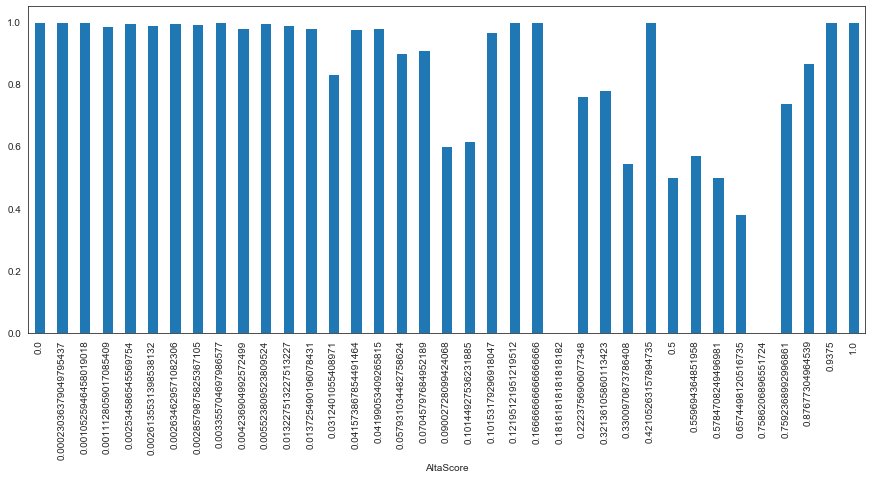

In [47]:
fig, ax = plt.subplots(figsize = (15, 6))
results_by_score['Mean'].plot(kind='bar')

# Curva AUC

In [59]:
print(metrics.roc_auc_score(results_df['dif_em_acount'], results_df['AltaScore']))

0.9650549399348973


In [60]:
fpr, tpr, _ = metrics.roc_curve(results_df['dif_em_acount'], results_df['AltaScore'])

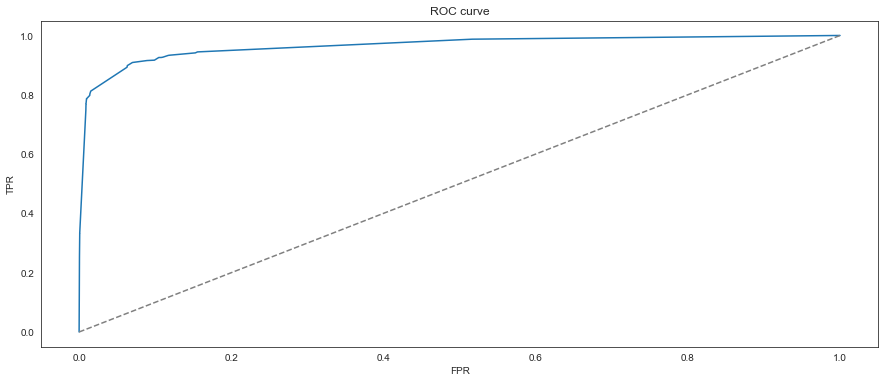

In [61]:
fig, ax = plt.subplots(figsize = (15, 6))
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [120]:
results_df

,dif_em_acount,altaPrediction,Success,AltaScore
5305408,0.00,0.00,1,0.00
5305409,0.00,0.00,1,0.00
5305410,0.00,0.00,1,0.00
5305411,0.00,0.00,1,0.00
5305412,0.00,0.00,1,0.00
...,...,...,...,...
5636991,0.00,0.00,1,0.42
5636992,0.00,0.00,1,0.42
5636993,0.00,0.00,1,0.42
5636994,0.00,0.00,1,0.42


In [124]:
results_df[ (results_df['Success']==0) &
            (results_df['AltaScore']> 0.40) &
            (results_df['AltaScore']< 0.50)]

,dif_em_acount,altaPrediction,Success,AltaScore
5305456,1.00,0.00,0,0.42
5305738,1.00,0.00,0,0.45
5305929,1.00,0.00,0,0.42
5305969,1.00,0.00,0,0.45
5306919,1.00,0.00,0,0.47
...,...,...,...,...
5636966,1.00,0.00,0,0.47
5636967,1.00,0.00,0,0.42
5636968,1.00,0.00,0,0.42
5636969,1.00,0.00,0,0.42


# Lo hacemos con valida:

In [88]:
y_valida_pred = pd.DataFrame(dt.predict(X_valida), index=Y_valida.index, columns=['CountPrediction'])

In [89]:
results_df = Y_valida.to_frame().join(y_valida_pred)

In [90]:
results_df

,dif_em_acount,CountPrediction
4973820,0.00,0.00
4973821,0.00,0.00
4973822,0.00,0.00
4973823,0.00,0.00
4973824,0.00,0.00
...,...,...
5303864,0.00,1.00
5303865,0.00,1.00
5303878,0.00,1.00
5303882,0.00,1.00


In [91]:
results_df[results_df['dif_em_acount']!=0].sample(40)

,dif_em_acount,CountPrediction
5181980,-1.00,-1.00
4992964,-1.00,0.00
5006839,1.00,0.00
5073869,1.00,1.00
5037208,-1.00,0.00
5301606,1.00,1.00
5129021,1.00,0.00
5303549,1.00,1.00
5301028,1.00,1.00
5254758,-1.00,0.00


In [92]:
results_df['error']=results_df['dif_em_acount']-results_df['CountPrediction']

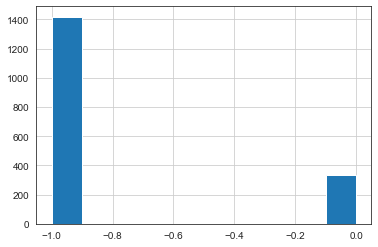

In [93]:
results_df[results_df['dif_em_acount']==-1]['error'].hist()

In [94]:
results_df[results_df['dif_em_acount']==-1]['error'].value_counts()

-1.00    1418
0.00      332
Name: error, dtype: int64

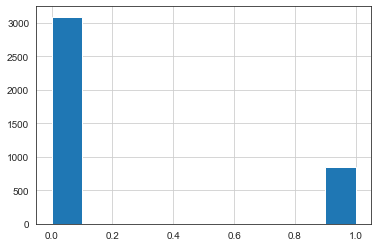

In [95]:
results_df[results_df['dif_em_acount']==1]['error'].hist()

In [96]:
results_df[results_df['dif_em_acount']==1]['error'].value_counts()

0.00    3089
1.00     852
Name: error, dtype: int64

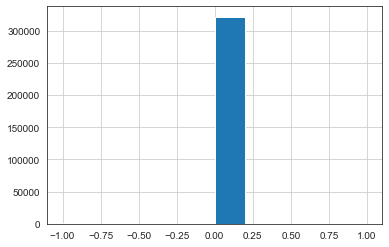

In [97]:
results_df[results_df['dif_em_acount']==0]['error'].hist()

In [98]:
results_df[results_df['dif_em_acount']==0]['error'].value_counts()

0.00     321722
-1.00      1100
1.00         33
Name: error, dtype: int64

In [99]:
top_features = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

In [100]:
top_features

totalAssets_shift_1              0.88
payroll_account_shift_1          0.04
dif_em_acount_shift_1            0.01
age                              0.01
dif_payroll_shift_1              0.01
debit_card_shift_1               0.01
month                            0.01
entry_date_year                  0.00
dif_short_term_deposit_shift_3   0.00
em_acount_shift_1                0.00
em_acount_shift_2                0.00
entry_date_month                 0.00
year                             0.00
mortgage_shift_1                 0.00
pension_plan_shift_2             0.00
active_customer_shift_1          0.00
payroll_shift_3                  0.00
channel_XXX                      0.00
em_acount_shift_3                0.00
totalCuentas_shift_1             0.00
dtype: float64

# Tunera modelo:

In [12]:
RANDOM_STATE=42

In [13]:
lista_x=[]
lista_strain=[]
lista_svalida=[]
for x in range(6,20):
    dt = DecisionTreeClassifier(max_depth=x,random_state=RANDOM_STATE)
    dt.fit(X_train,Y_train)
    score_train=dt.score(X_train, Y_train)
    score_valida=dt.score(X_valida, Y_valida)
    print('Resultados para x: {} Train: {} - Test: {}'.format(x,score_train,score_valida))
    lista_x.append(x)
    lista_strain.append(score_train)
    lista_svalida.append(score_valida)
score_df=pd.DataFrame(index=lista_x, data={'Score_train':lista_strain, 'Score_test':lista_svalida})

Resultados para x: 6 Train: 0.9916425300228778 - Test: 0.9947222002398447
Resultados para x: 7 Train: 0.9918306656230681 - Test: 0.9944787031344164
Resultados para x: 8 Train: 0.99207294589508 - Test: 0.9945243588416842
Resultados para x: 9 Train: 0.9923933589846572 - Test: 0.9944452222824202
Resultados para x: 10 Train: 0.9927816242579096 - Test: 0.994262599453349


KeyboardInterrupt: 

In [ ]:
# Vamos a pintar los resultados obtenidos para ver con que valor nos quedamos:
fig = go.Figure()
fig.update_layout(title_text='Relación de Score con max_depth:')
fig.add_trace(go.Scatter(x=score_df.index,y=score_df['Score_train'], mode='lines+markers', name='Score_train'))
fig.add_trace(go.Scatter(x=score_df.index,y=score_df['Score_test'], mode='lines+markers', name='Score_test'))
fig.show()

In [93]:
RANDOM_STATE=42
lista_x=[]
lista_strain=[]
lista_stest=[]
for i in range(10,100,30):
    xg_reg = xgb.XGBClassifier(colsample_bytree = 0.3, learning_rate = 0.05, alpha = 10, n_estimators = i, 
                                max_depth=7,random_state=RANDOM_STATE)
    xg_reg.fit(X_train,Y_train)
    score_train=xg_reg.score(X_train, Y_train)
    score_test=xg_reg.score(X_test, Y_test)
    print('n_stimators: {}. Train: {} - Test: {}'.format(i,score_train,score_test))
    lista_x.append(i)
    lista_strain.append(score_train)
    lista_stest.append(score_test)
score_df=pd.DataFrame(index=lista_x, data={'Score_train':lista_strain, 'Score_test':lista_stest})


n_stimators: 10. Train: 0.9906127531948783 - Test: 0.9951687033306392
n_stimators: 40. Train: 0.9906257753311393 - Test: 0.9950390243313992


KeyboardInterrupt: 

In [ ]:
# Vamos a pintar los resultados obtenidos para ver con que valor nos quedamos:
fig = go.Figure()
fig.update_layout(title_text='Relación de Score con max_depth:')
fig.add_trace(go.Scatter(x=score_df.index,y=score_df['Score_train'], mode='lines+markers', name='Score_train'))
fig.add_trace(go.Scatter(x=score_df.index,y=score_df['Score_test'], mode='lines+markers', name='Score_test'))
fig.show()